In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Library Imports**

In [2]:
import re #libray for regular expression
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


# Loading Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Github Projects/3. Spam Detection in Emails/completeSpamAssassin.csv')

In [5]:
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


# **Data Cleaning and Preprocessing**

In [6]:
df = df.drop(columns = 'Unnamed: 0', axis='columns')
df = df[df['Body']!= 'empty']

In [7]:
df['Body'].duplicated().sum()

221

In [8]:
df = df.drop_duplicates()

In [9]:
df.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [11]:
data = df.where((pd.notnull(df)), '')

In [12]:
data.isna().sum().sum()

0

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5292 entries, 0 to 6043
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    5292 non-null   object
 1   Label   5292 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 124.0+ KB


In [14]:
data.shape

(5292, 2)

In [15]:
data.reset_index(drop=True, inplace=True)

In [21]:
y = df['Label'].values


# **Text Vecorization**

In [16]:
ps = PorterStemmer()
corpus = []
for index, row in data.iterrows():
  review = re.sub('[^a-zA-Z]', ' ', row['Body'])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus.append(review)

In [17]:
tokenized_corpus = [sentence.split() for sentence in corpus]

# Train a Word2Vec model on the tokenized corpus
word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=128, window=5, min_count=1, workers=4)

In [18]:
max_words = 5000  # Max words to keep
max_length = 100  # Max length of sequences

In [19]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(corpus)
X = tokenizer.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen=max_length)

In [22]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# **Train Test Split**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=3)



In [24]:
embedding_dim = 128  # Same as Word2Vec vector size
vocab_size = min(len(tokenizer.word_index) + 1, max_words)

In [25]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [26]:
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# **Model Training and Performance Metrics**

In [31]:
def build_and_train_model(model_type="RNN"):
    model = Sequential([
        embedding_layer,  # Use pre-trained Word2Vec embeddings
    ])

    if model_type == "RNN":
        model.add(SimpleRNN(128, activation='relu', return_sequences=True))
        model.add(Dropout(0.5))
        model.add(SimpleRNN(64, activation='relu'))
    elif model_type == "LSTM":
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Dropout(0.5))
        model.add(LSTM(64))
    elif model_type == "GRU":
        model.add(Bidirectional(GRU(128, return_sequences=True)))
        model.add(Dropout(0.5))
        model.add(GRU(64))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print(f"\nTraining {model_type} Model...")
    model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

    return model


In [32]:
rnn_model = build_and_train_model("RNN")
lstm_model = build_and_train_model("LSTM")
gru_model = build_and_train_model("GRU")



Training RNN Model...
Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.6180 - loss: 0.7498 - val_accuracy: 0.7784 - val_loss: 0.4338
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7750 - loss: 0.4689 - val_accuracy: 0.8806 - val_loss: 0.3292
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8424 - loss: 0.3759 - val_accuracy: 0.8685 - val_loss: 0.3744
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8916 - loss: 0.2862 - val_accuracy: 0.9189 - val_loss: 0.2244
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9159 - loss: 0.2471 - val_accuracy: 0.9323 - val_loss: 0.1808
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9362 - loss: 0.1921 - val_accuracy: 0.9374 - val_loss: 0.1718
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9416 - loss: 0.1631 - val_accuracy: 0.9368 - val_loss: 0.1853
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9324 - loss: 0.1891 - 

In [33]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print performance metrics
    print(f"\n{name} Model Performance:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Compute and visualize confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    return accuracy, precision, recall, f1

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

RNN Model Performance:
Accuracy: 0.96
Precision: 0.94
Recall: 0.98
F1 Score: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96       774
           1       0.94      0.98      0.96       792

    accuracy                           0.96      1566
   macro avg       0.96      0.96      0.96      1566
weighted avg       0.96      0.96      0.96      1566



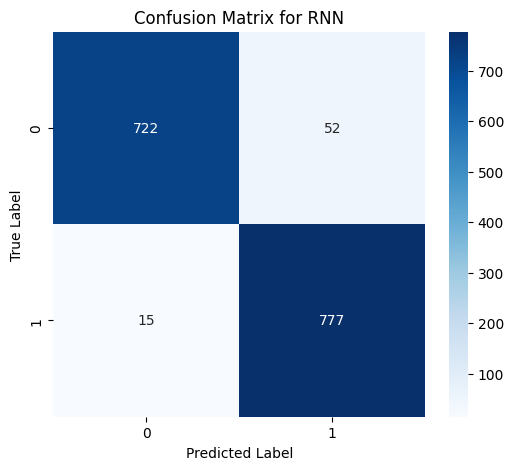

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

LSTM Model Performance:
Accuracy: 0.98
Precision: 0.99
Recall: 0.98
F1 Score: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       774
           1       0.99      0.98      0.98       792

    accuracy                           0.98      1566
   macro avg       0.98      0.98      0.98      1566
weighted avg       0.98      0.98      0.98      1566



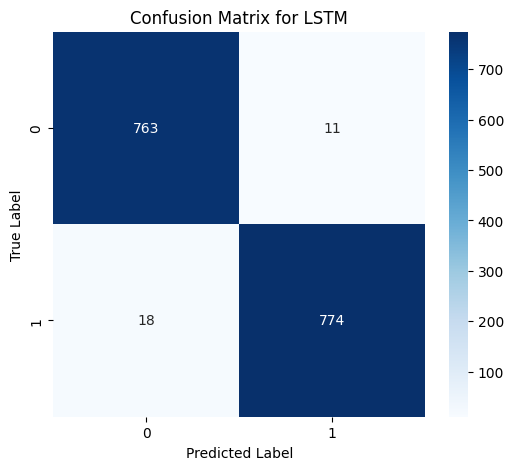

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

GRU Model Performance:
Accuracy: 0.98
Precision: 0.99
Recall: 0.97
F1 Score: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       774
           1       0.99      0.97      0.98       792

    accuracy                           0.98      1566
   macro avg       0.98      0.98      0.98      1566
weighted avg       0.98      0.98      0.98      1566



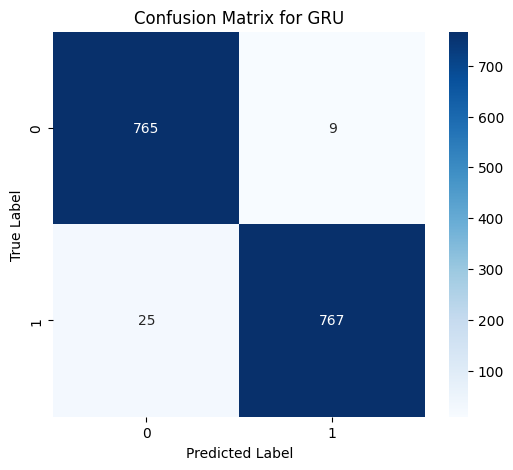

(0.9782886334610472,
 0.9884020618556701,
 0.9684343434343434,
 0.9783163265306123)

In [34]:
evaluate_model(rnn_model, X_test, y_test, "RNN")
evaluate_model(lstm_model, X_test, y_test, "LSTM")
evaluate_model(gru_model, X_test, y_test, "GRU")